In [40]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import pandapower as pp # type: ignore
import matplotlib.pyplot as plt # type: ignore 


In [41]:
#Sistema varias barras
net = pp.create_empty_network()

barra1 = pp.create_bus(net, vn_kv=110, name="Barra 1")
barra2 = pp.create_bus(net, vn_kv=220, name="Barra 2")
barra1A = pp.create_bus(net, vn_kv=220, name="Barra 1A")
barra1B = pp.create_bus(net, vn_kv=220, name="Barra 1B")
barra2A = pp.create_bus(net, vn_kv=220, name="Barra 2A")
barra2B = pp.create_bus(net, vn_kv=220, name="Barra 2B")
barra3A = pp.create_bus(net, vn_kv=220, name="Barra 3A")

pp.create_transformer(net, barra2, barra1, std_type="100 MVA 220/110 kV")

pp.create_ext_grid(net, barra1, vm_pu=1.0, name="Slack bus")

pp.create_load(net, barra1A, p_mw=30, q_mvar=20, name="Carga 1A")
pp.create_load(net, barra1B, p_mw=15, q_mvar=10, name="Carga 1B")
pp.create_load(net, barra2A, p_mw=52.5, q_mvar=35, name="Carga 2A")
pp.create_load(net, barra2B, p_mw=90, q_mvar=60, name="Carga 2B")
pp.create_load(net, barra3A, p_mw=22.5, q_mvar=15, name="Carga 3A")


pp.create_line(net, barra2, barra1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="L2-1A")
pp.create_line(net, barra1A, barra2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="L1A-2A")
pp.create_line(net, barra2A, barra3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="L2A-3A")
pp.create_line(net, barra3A, barra2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="L3A-2B")
pp.create_line(net, barra2B, barra1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="L2B-1B")
pp.create_line(net, barra1B, barra2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="L1-B2")

5

In [42]:
pp.runpp(net, algorithm='nr', numba=False,max_iteration=100)

In [43]:
net.res_line.index = net.line.name
net.res_bus.index = net.bus.name

In [44]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
name,,,,
Barra 1,1.000000,0.000000,-212.310191,5.807279
Barra 2,1.033380,-14.276471,0.000000,0.000000
Barra 1A,1.031457,-14.492303,30.000000,20.000000
Barra 1B,1.032375,-14.469768,15.000000,10.000000
Barra 2A,1.029237,-14.730336,52.500000,35.000000
Barra 2B,1.027435,-14.873522,90.000000,60.000000
Barra 3A,1.028365,-14.864945,22.500000,15.000000


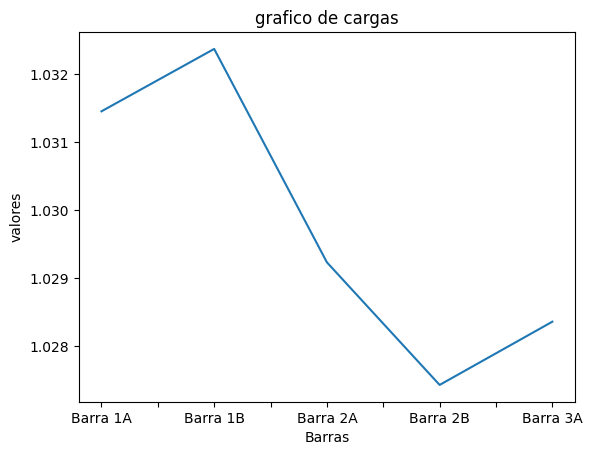

In [45]:
df = net.res_bus

df['vm_pu'][2:7].plot(kind='line')
plt.title('grafico de cargas')
plt.xlabel('Barras')
plt.ylabel('valores')
plt.show()

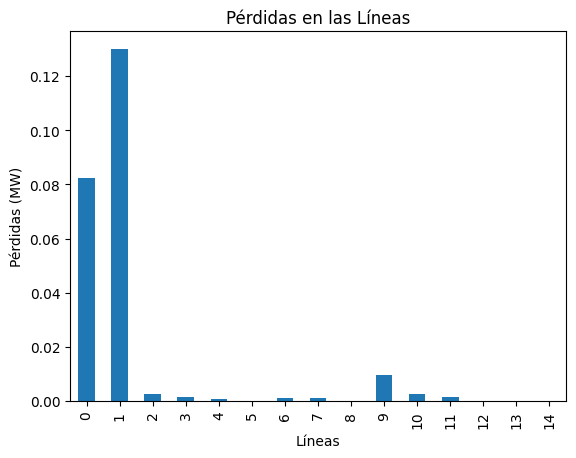

In [56]:
# Calcular pérdidas
net.res_line['loss_mw'] = net.res_line.pl_mw

# Graficar pérdidas
net.res_line.loss_mw.plot(kind='bar')
plt.xlabel('Líneas')
plt.ylabel('Pérdidas (MW)')
plt.title('Pérdidas en las Líneas')
plt.show()


In [46]:
#sistema 2 barras

red = pp.create_empty_network()

bar1 = pp.create_bus(red, vn_kv=500, name="Barra 1")
bar2 = pp.create_bus(red, vn_kv=500, name="Barra 2")

pp.create_ext_grid(red, bar1, vm_pu=1.0, name="Generador")

pp.create_line_from_parameters(red, bar1, bar2, length_km=500, r_ohm_per_km=0.02, x_ohm_per_km=0.115, c_nf_per_km=19.1, max_i_ka=1)
pp.create_line_from_parameters(red, bar1, bar2, length_km=500, r_ohm_per_km=0.02, x_ohm_per_km=0.115, c_nf_per_km=19.1, max_i_ka=1)

pp.create_load(red, bar2, p_mw=1.08, q_mvar=0.523, name="Carga")

pp.runpp(red, algorithm='nr', numba=False,max_iteration=100)

In [47]:
red.res_line.index = red.line.name
red.res_bus.index = red.bus.name

red.res_bus

,vm_pu,va_degree,p_mw,q_mvar
name,,,,
Barra 1,1.000000,0.000000,-14.534853,1570.135345
Barra 2,1.094168,-0.946436,1.080000,0.523000


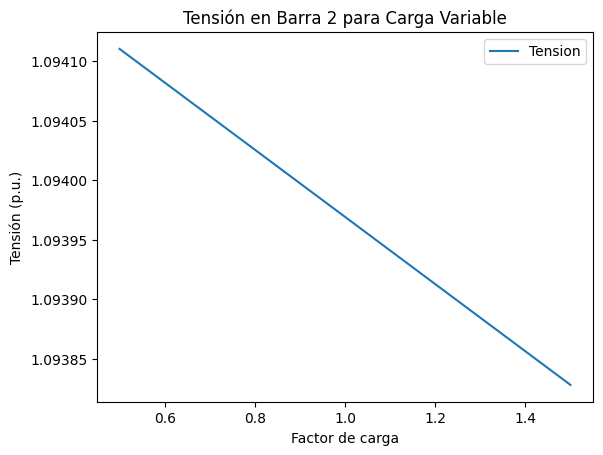

In [51]:

# Definir rango de factores de carga (±50%)
load_factors = np.linspace(0.5, 1.5, 10)

# Lista para almacenar resultados de tensión en la barra 2
voltages_bar2 = []

# Guardar el valor inicial de la carga en la barra 2
initial_p_mw = red.load.loc[red.load.name == 'Carga', 'p_mw'].values[0]
initial_q_mvar = red.load.loc[red.load.name == 'Carga', 'q_mvar'].values[0]

# Función para ajustar la carga en la barra 2
def adjust_load(factor):
    red.load.loc[red.load.name == 'Carga', 'p_mw'] = initial_p_mw * factor
    red.load.loc[red.load.name == 'Carga', 'q_mvar'] = initial_q_mvar * factor

# Simular para diferentes factores de carga
for factor in load_factors:
    adjust_load(factor)
    pp.runpp(red, numba=False)
    # Guardar tensión en la barra 2
    voltages_bar2.append(red.res_bus.loc[red.res_bus.index == bar2, 'vm_pu'].values[0])

# Convertir resultados a DataFrame para graficar
voltage_df = pd.DataFrame(voltages_bar2, columns=['Tension'], index=load_factors)

# Graficar resultados
voltage_df.plot()
plt.xlabel('Factor de carga')
plt.ylabel('Tensión (p.u.)')
plt.title('Tensión en Barra 2 para Carga Variable')
plt.show()
